In [17]:
import pyabc
import numpy as np
import os
from study_abc_noise.model import ConversionReactionModelVars as ModelVars
import matplotlib.pyplot as plt
%matplotlib inline

arr_n_t = [3, 6, 10, 30, 60, 100, 300, 1000]
arr_approach = ['stochacc', 'stochacc_badc', 'rejection', 'rejection_badc', 'noisymodel']
arr_approach = ['stochacc', 'stochacc_badc', 'rejection', 'noisymodel']
mv = ModelVars()

arr_hs = []
success = []

for i, n_t in enumerate(arr_n_t):
    arr_hs.append([])
    success.append([])
    for approach in arr_approach:
        f = f"cr_{n_t}_{approach}.db"
        if not os.path.isfile(f):
            hs[i].append(None)
            success[i].append(False)
            continue
        _h = pyabc.History(f"sqlite:///{f}")
        arr_hs[i].append(_h)
        last_eps = _h.get_all_populations()['epsilon'].iloc[-1]
        success[i].append(True if approach == 'noisymodel' or last_eps == 1.0 else False)

success = np.array(success)
total_samples = []
for i, n_t in enumerate(arr_n_t):
    total_samples.append([])
    for j, approach in enumerate(arr_approach):
        h = hs[i][j]
        if h is None:
            total_samples[i].append(None)
        else:
            total_samples[i].append(np.sum(h.get_all_populations()['samples']))

total_samples = np.array(total_samples)
max_samples = np.max(total_samples)

## Plot all posteriors

3
  stochacc
  stochacc_badc
  rejection
  noisymodel
  stochacc
  stochacc_badc
  rejection
  noisymodel
6
  stochacc
  stochacc_badc
  rejection
  noisymodel
  stochacc
  stochacc_badc
  rejection
  noisymodel
10
  stochacc
  stochacc_badc
  rejection
  noisymodel


/home/yannik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


  stochacc
  stochacc_badc
  rejection
  noisymodel
30
  stochacc
  stochacc_badc
  rejection
  noisymodel
  stochacc
  stochacc_badc
  rejection
  noisymodel
60
  stochacc
  stochacc_badc
  rejection
  noisymodel
  stochacc
  stochacc_badc
  rejection
  noisymodel
100
  stochacc
  stochacc_badc
  rejection
  noisymodel
  stochacc
  stochacc_badc
  rejection
  noisymodel
300
  stochacc
  stochacc_badc
  rejection
  noisymodel
  stochacc
  stochacc_badc
  rejection
  noisymodel
1000
  stochacc
  stochacc_badc
  rejection
  noisymodel
  stochacc
  stochacc_badc
  rejection
  noisymodel


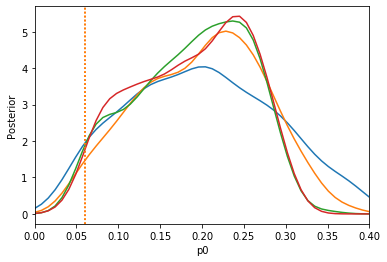

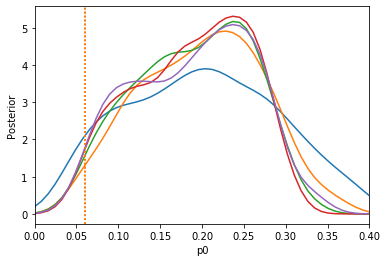

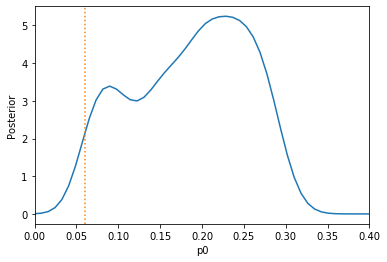

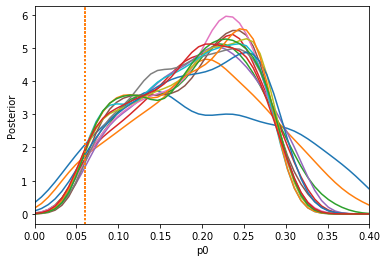

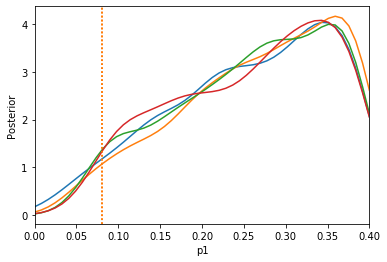

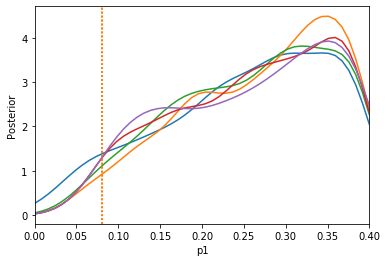

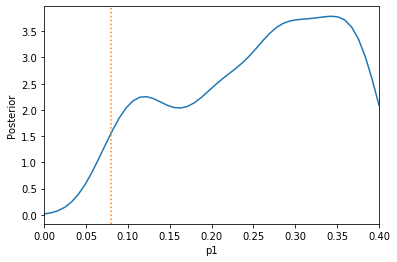

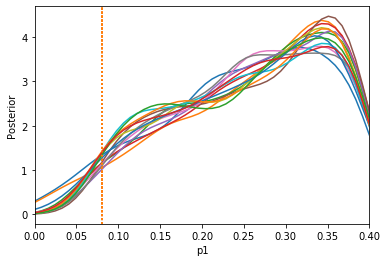

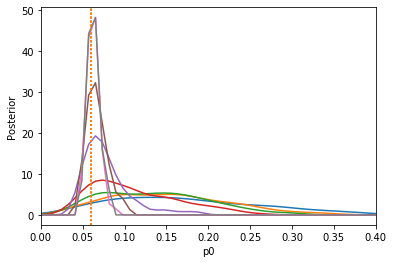

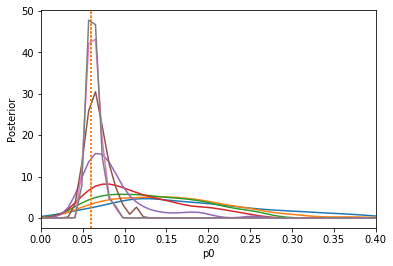

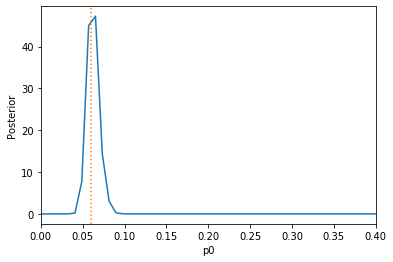

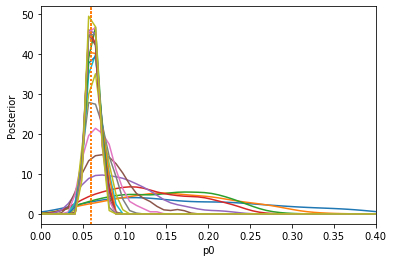

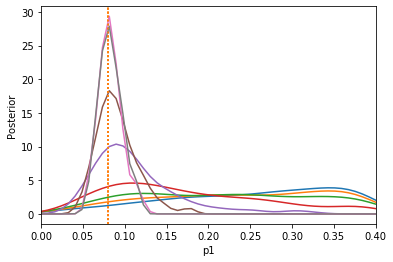

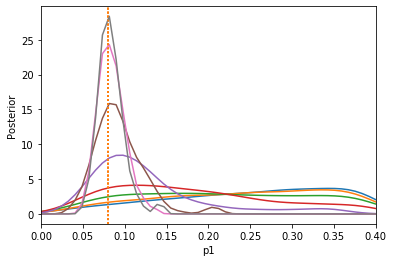

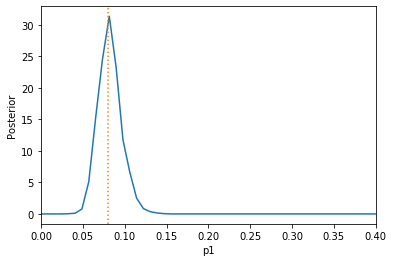

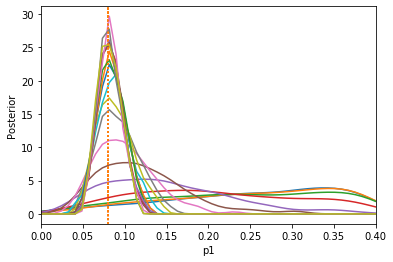

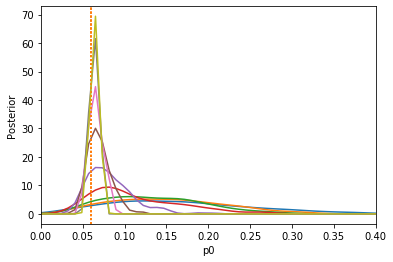

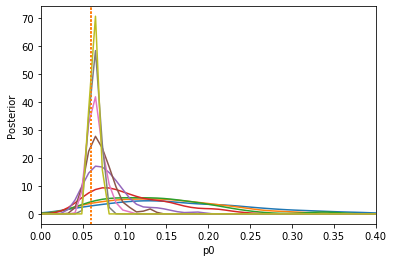

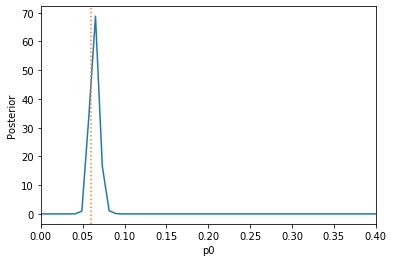

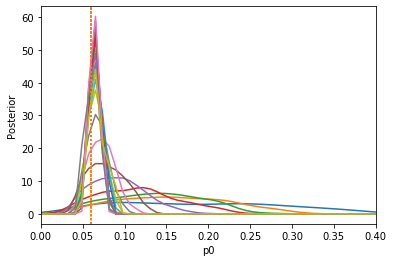

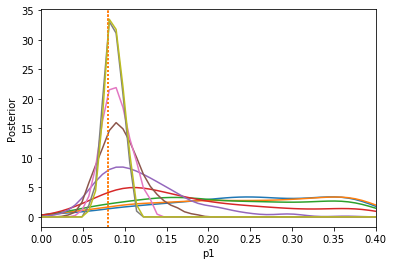

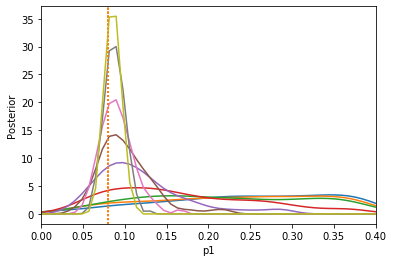

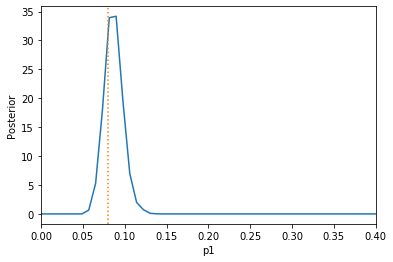

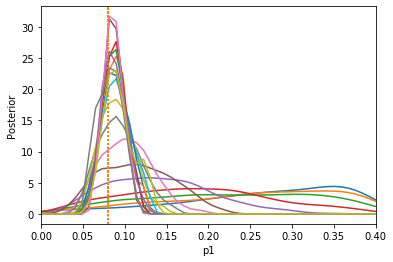

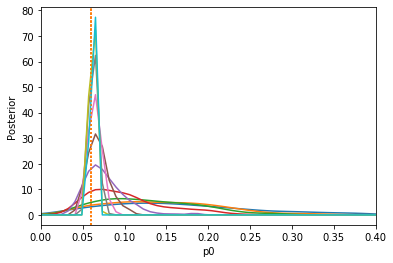

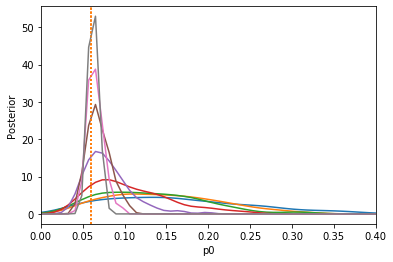

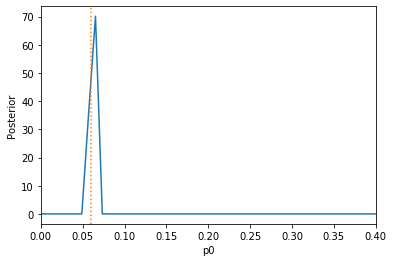

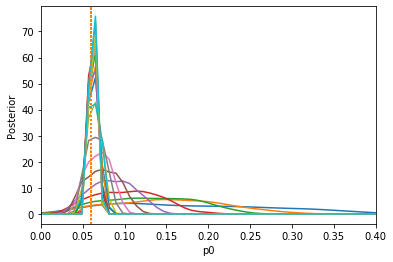

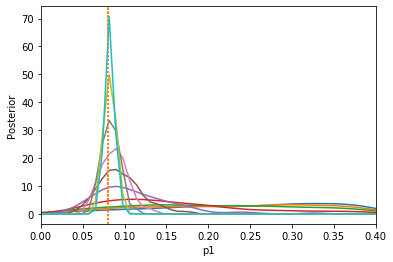

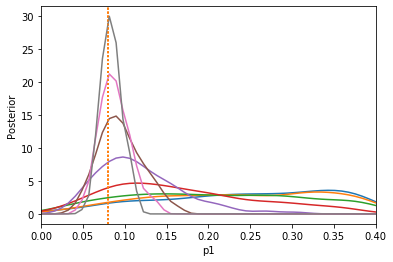

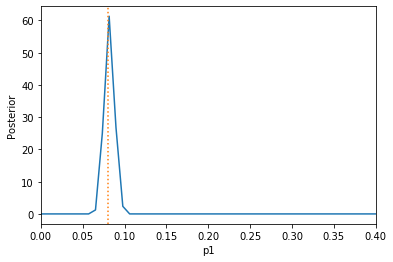

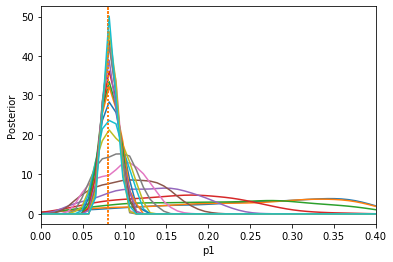

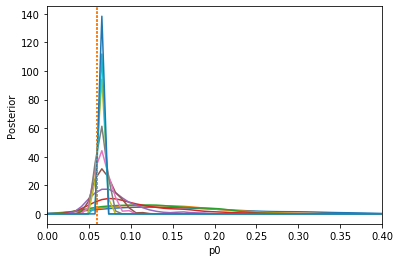

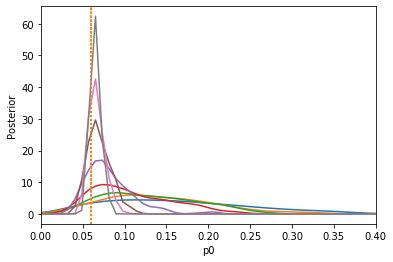

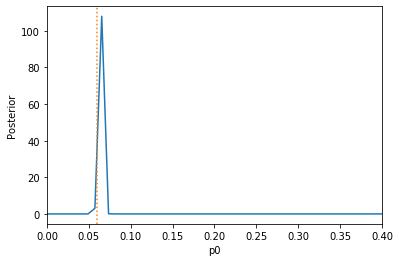

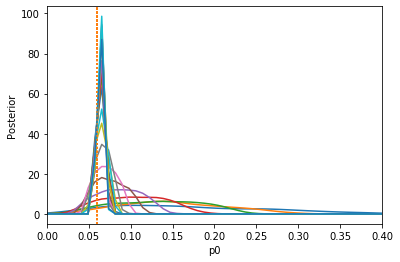

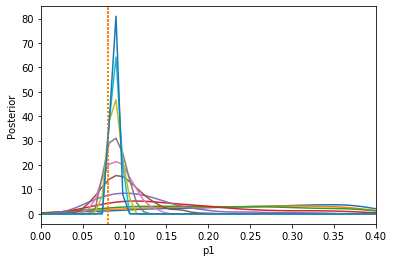

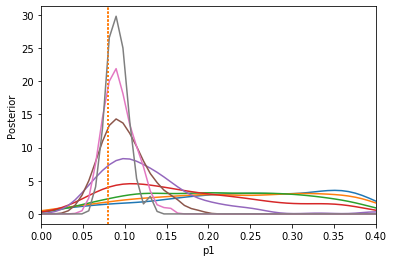

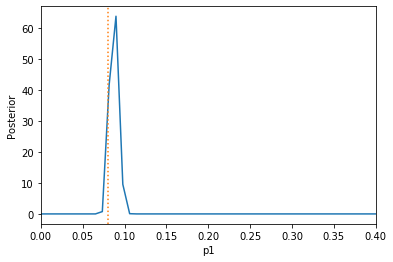

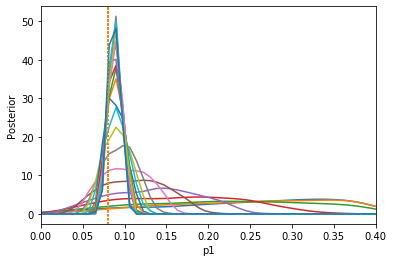

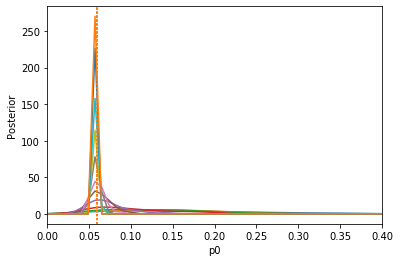

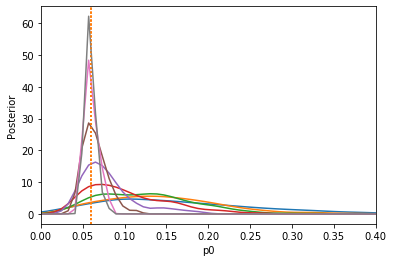

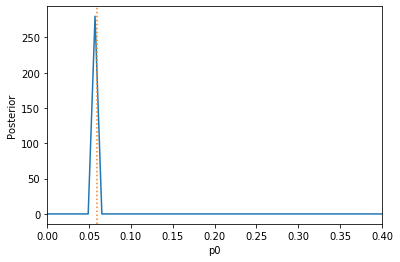

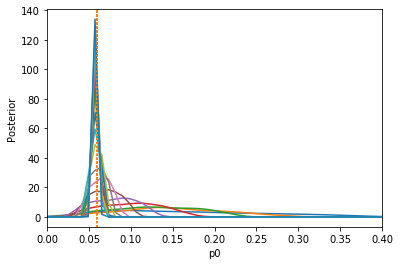

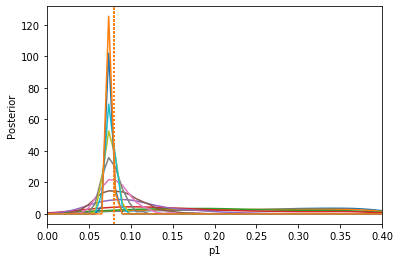

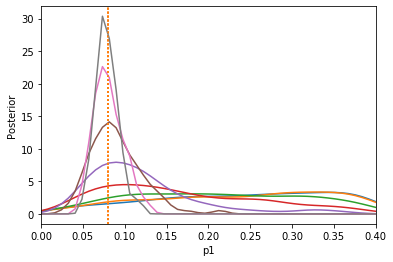

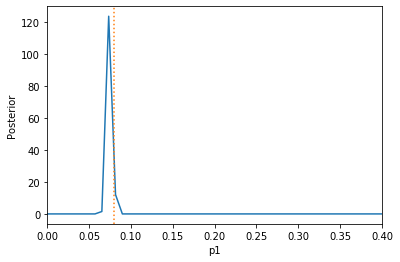

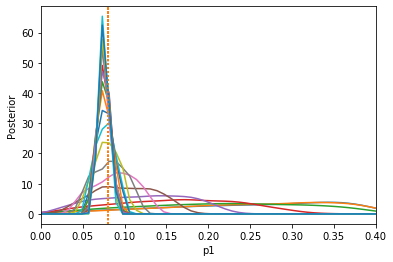

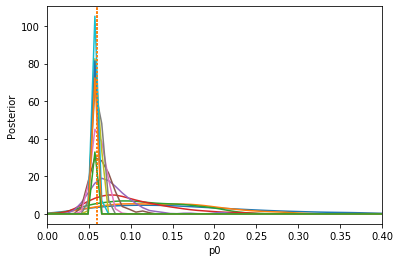

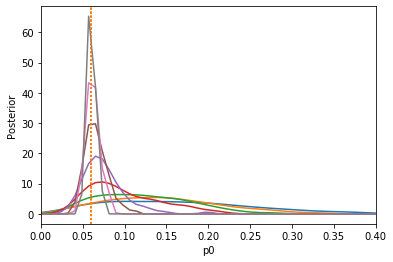

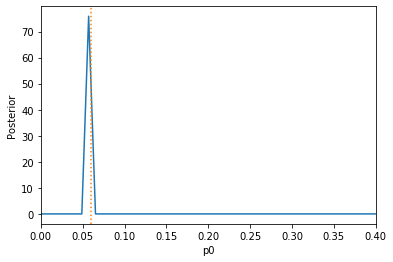

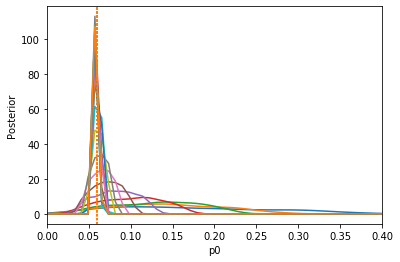

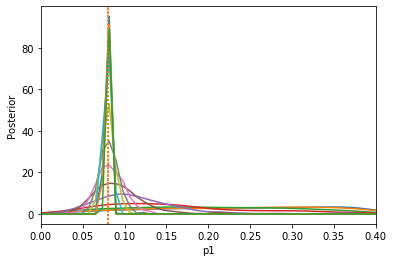

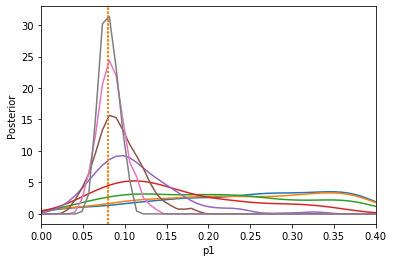

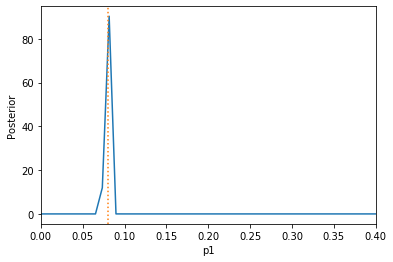

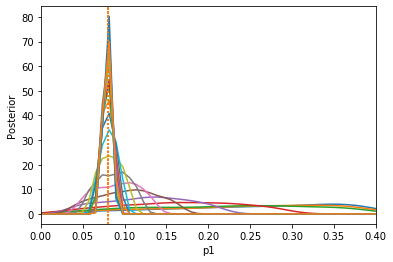

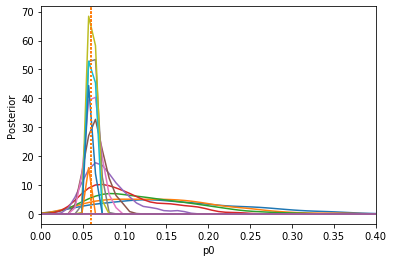

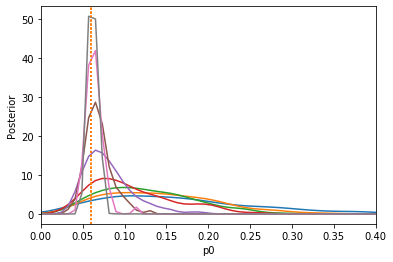

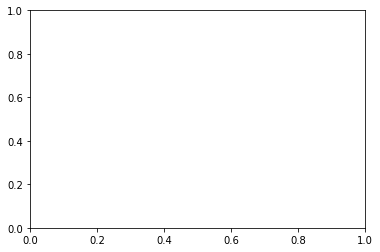

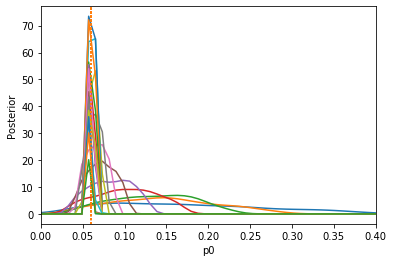

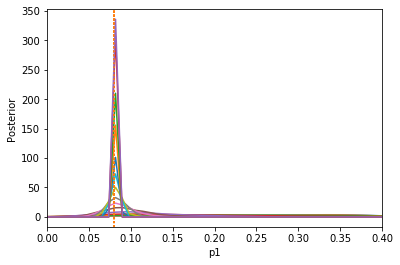

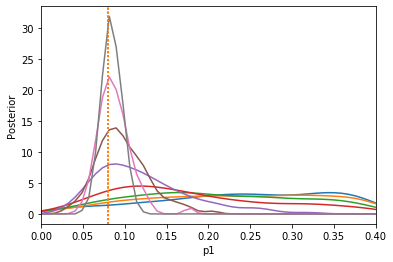

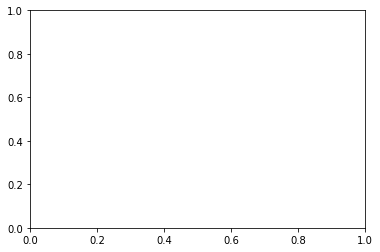

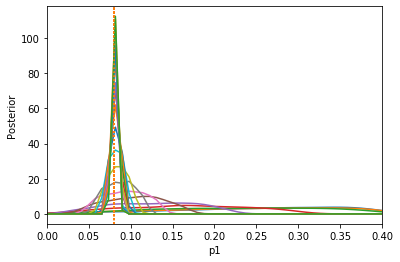

In [25]:
for t, hs in zip(arr_n_t, arr_hs):
    print(t)
    #_, ax = plt.subplots(1, 2)
    for ip, p in enumerate(mv.p_true):
        for h, approach in zip(hs, arr_approach):
            _, ax = plt.subplots()
            print(" ", approach)
            for t in range(0, h.max_t + 1):
                pyabc.visualization.plot_kde_1d_highlevel(
                    h, x=p, xmin=mv.limits[p][0], xmax=mv.limits[p][1], t=t, 
                    ax=ax, refval=mv.p_true)
            #ax.legend()

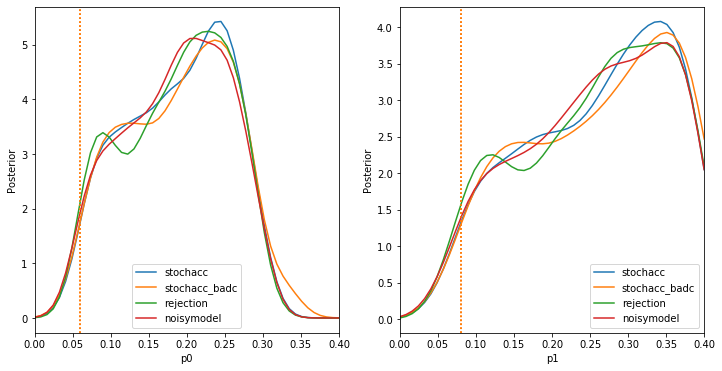

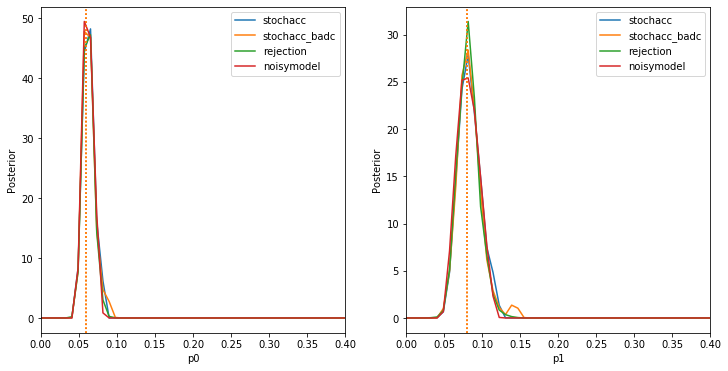

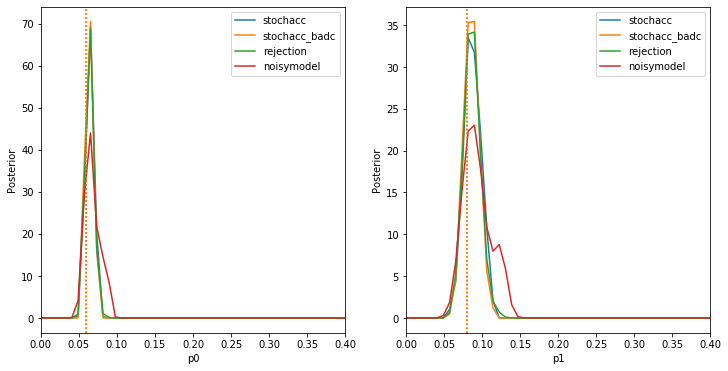

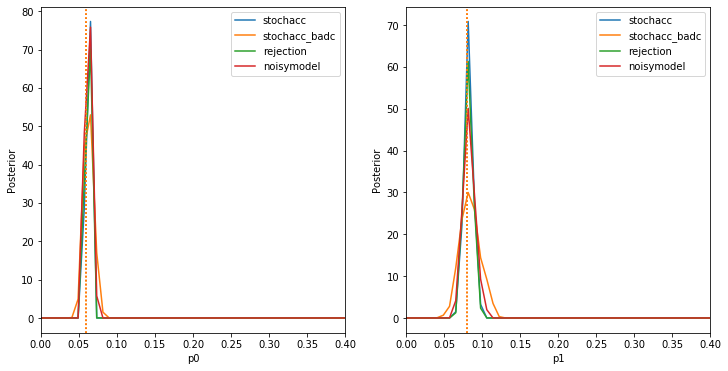

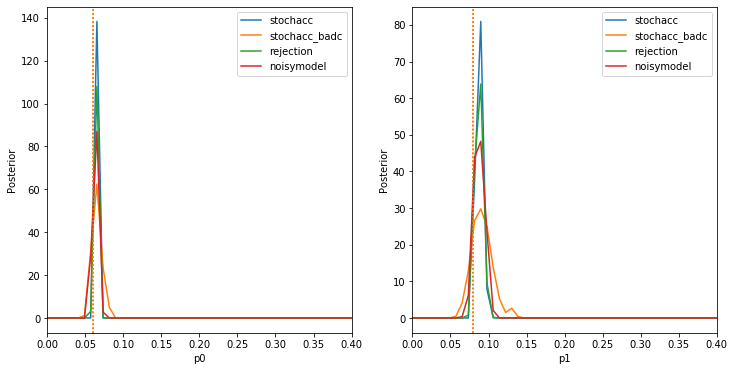

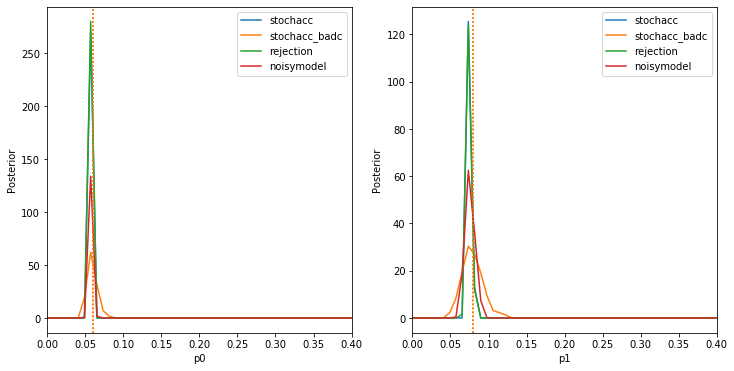

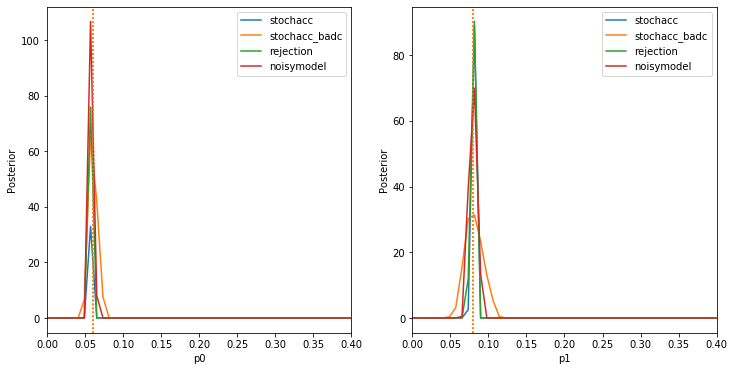

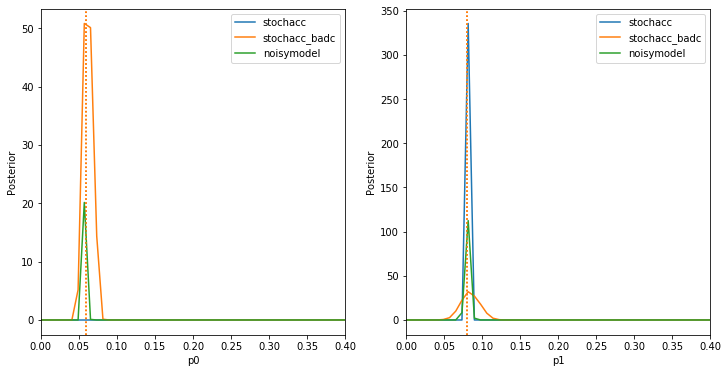

In [28]:
for t, hs in zip(arr_n_t, arr_hs):
    _, ax = plt.subplots(1, 2)
    for ip, p in enumerate(mv.p_true):
        for h, approach in zip(hs, arr_approach):
            if h.max_t >= 0:
                pyabc.visualization.plot_kde_1d_highlevel(
                    h, x=p, xmin=mv.limits[p][0], xmax=mv.limits[p][1], t=None, 
                    ax=ax[ip], refval=mv.p_true, label=approach)
        ax[ip].legend()
    plt.gcf().set_size_inches((12, 6))

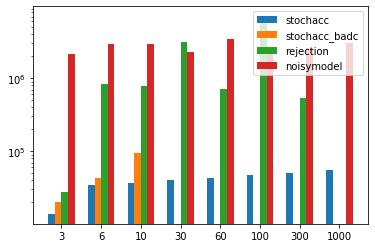

In [10]:
_, ax = plt.subplots()

barwidth = 1 / (len(arr_approach) + 2)
for i, approach in enumerate(arr_approach):
    _samples = total_samples[:, i]
    _success = success[:, i]
    for j, _s in enumerate(_success):
        if not _s:
            _samples[j] = 0
    p = np.arange(len(arr_n_t)) + (i+0.5-len(arr_approach)/2) * barwidth
    ax.bar(p, _samples, width=barwidth, label=approach)
ax.set_yscale('log')
ax.set_xticks(np.arange(len(arr_n_t)))
ax.set_xticklabels(arr_n_t)
ax.legend(loc='upper right')
#ax.set_ylim([0, 2e6])

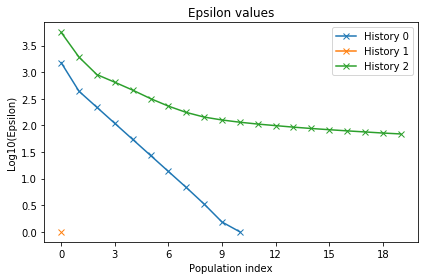

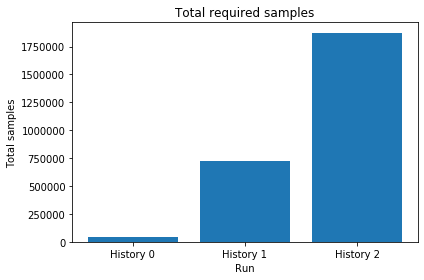

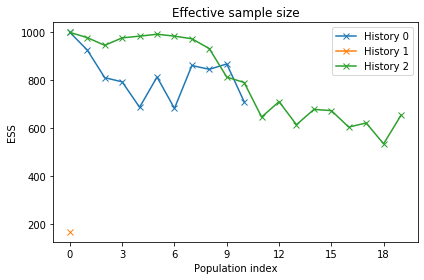

In [8]:
pyabc.visualization.plot_epsilons(hs[60], scale='log10')
pyabc.visualization.plot_total_sample_numbers(hs[60], yscale='lin')
pyabc.visualization.plot_effective_sample_sizes(hs[60])


[<pyabc.storage.history.History object at 0x7f5b62c1a470>, <pyabc.storage.history.History object at 0x7f5b62d332e8>, <pyabc.storage.history.History object at 0x7f5b62ed9668>, <pyabc.storage.history.History object at 0x7f5b62ed9be0>]


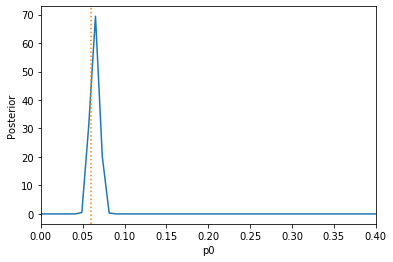

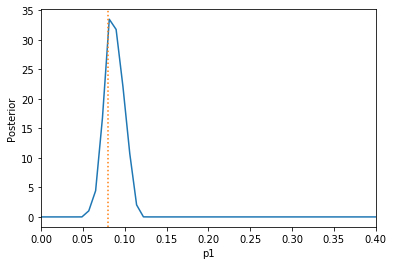

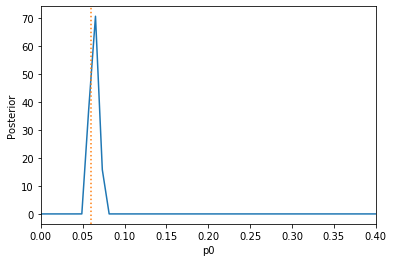

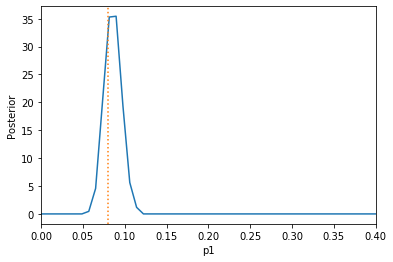

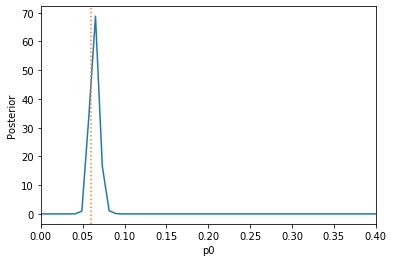

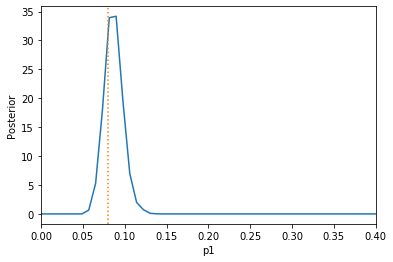

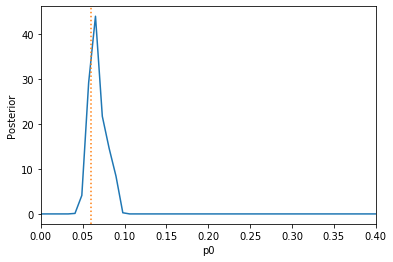

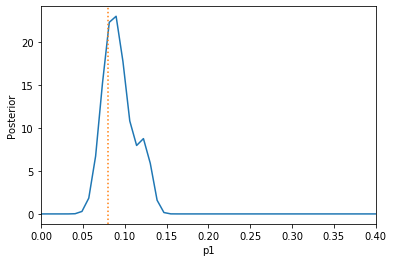

In [15]:
print(hs[2])
def plot_posterior(_h):
    for p in mv.p_true:
        _, ax = plt.subplots()
        #for t in range(_h.max_t+1):
        pyabc.visualization.plot_kde_1d_highlevel(
            _h, x=p, xmin=mv.limits[p][0], xmax=mv.limits[p][1], t=None, ax=ax, refval=mv.p_true)

for i in range(4):
    plot_posterior(hs[2][i])


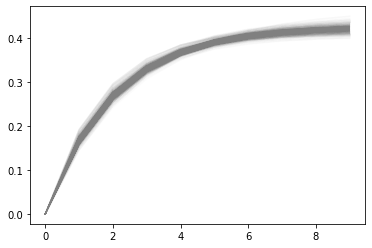

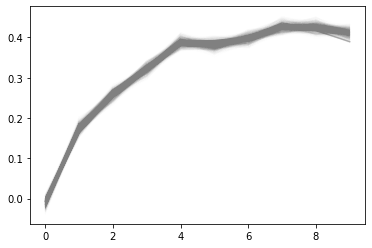

In [4]:
def plot_data(sum_stat, weight, ax, **kwargs):
    ax.plot(sum_stat['y'], color='grey', alpha=5*weight)
    
pyabc.visualization.plot_data_callback(hs[10][0], plot_data)
pyabc.visualization.plot_data_callback(hs[10][2], plot_data)

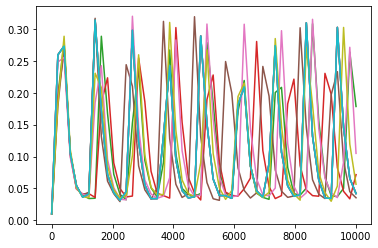

In [7]:
from study_abc_noise.model import HodgkinHuxleyModelVars as ModelVars
import matplotlib.pyplot as plt

mv = ModelVars(basedir="..")
for _ in range(10):
    d = mv.get_model()(mv.p_true)
    plt.plot(d['K'])